In [1]:
import pickle as pkl
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from itertools import product

In [2]:
#Load the data
results = []
#Change this to wherever you have the data
PATH = "../Data/results/all_results/"
for filen in glob(PATH + "**/*.pkl",recursive=True):
    #Ignore the config files
    if filen[-10:]!='config.pkl':
        with open(filen, 'rb') as file:
            item = pkl.load(file)
            item['filename'] = filen
            item['id'] = len(results)
            results.append(item)

In [3]:
print(len(results))
results[53]

56


{'continue': [29.90000000000009,
  65.30000000000007,
  41.90000000000009,
  84.20000000000005,
  119.30000000000007,
  60.80000000000007,
  98.10000000000002,
  70.10000000000002,
  30.200000000000045,
  90.90000000000009,
  38.90000000000009,
  53.700000000000045,
  102.40000000000009,
  47.90000000000009,
  90.60000000000002,
  60.40000000000009,
  115.90000000000009,
  106.0,
  45.80000000000007,
  45.200000000000045,
  103.20000000000005,
  110.90000000000009,
  123.40000000000009,
  14.5,
  53.700000000000045],
 'random': [46.78999999999999,
  43.22,
  7.170000000000002,
  25.97,
  48.02000000000001,
  30.390000000000015,
  62.03999999999999,
  19.78,
  3.3599999999999994,
  47.390000000000015,
  139.87,
  73.94,
  59.06,
  115.15,
  39.110000000000014,
  26.019999999999996,
  93.83000000000001,
  40.71000000000001,
  12.950000000000003,
  43.93000000000001,
  40.02000000000001,
  45.80000000000001,
  55.74000000000001,
  0.0,
  22.53],
 'cont_deriv_fit': [(9.266786125672333e-07,

In [5]:
#Split the data by system

results_split = {item:[] for item in {'lorenz', 'thomas', 'rossler', 'softrobot'}}

#Exclude specific experiments
exclude_ids = {13,15,19,21}
for item in results:
    if item['id'] not in exclude_ids:
        results_split[item['experiment'][0]].append(item)

for name in results_split:
    print(f"{name}: {len(results_split[name])} items")

lorenz: 13 items
thomas: 15 items
softrobot: 12 items
rossler: 12 items


In [6]:
#Determine which experiments are missing
SYSTEM = ["lorenz", "rossler", "thomas", "softrobot"]
MAP_INITIAL = ["random", "activ_f", "relax"]
PREDICTION_TYPE = ["continue", "random"]
METHOD = ["standard", "augmented"]
all_exps = {item for item in product(SYSTEM, MAP_INITIAL, PREDICTION_TYPE, METHOD)}
ran_exps = {item['experiment'] for item in results}
missing = all_exps.difference(ran_exps)
if len(missing)==0:
    print("No experiments missing.")
else:
    print("Missing experiments:")
    for item in missing:
        print(item)

No experiments missing.


# Analysis - boxplots

In [25]:
def boxplots(data_list, which, sort=True, force_finite=False):
    """
    Given a list of results dictionaries and an attribute, makes a boxplot of each of the dictionary's data.
    Note: does not call plt.show()
    
    Parameters:
        data_list: list of results dictionaries.
        which (str): which item in the dictionary to plot.
        sort (bool): default True; if True, sort the datasets in descending order by median.
        force_finite (bool): default False; if True, remove any Inf or NaN values in the datasets before plotting.
    """
    names = np.array([str(item['id'])+': '+' '.join(item['experiment'][1:]) for item in data_list])
    data = [item[which] for item in data_list]
    if force_finite:
        #Remove any inf or nan values
        data = [np.array(item) for item in data]
        data = [item[np.isfinite(item)] for item in data]
    firstlen = len(data[0])
    same_len = np.all([firstlen == len(item) for item in data])
    if same_len:
        data_array = np.array(data)
        if sort:
            means = np.median(data_array,axis=1)
            order = np.argsort(means).astype(int)
        else:
            order = np.arange(data_array.shape[0]).astype(int)
        plt.boxplot(data_array[order,:].T, labels=names[order], vert=False)
    else:
        if sort:
            means = [np.median(item) for item in data]
            order = np.argsort(means).astype(int)
            data = [data[i] for i in order]
            names = [names[i] for i in order]
            
        plt.boxplot(data, labels=names, vert=False)

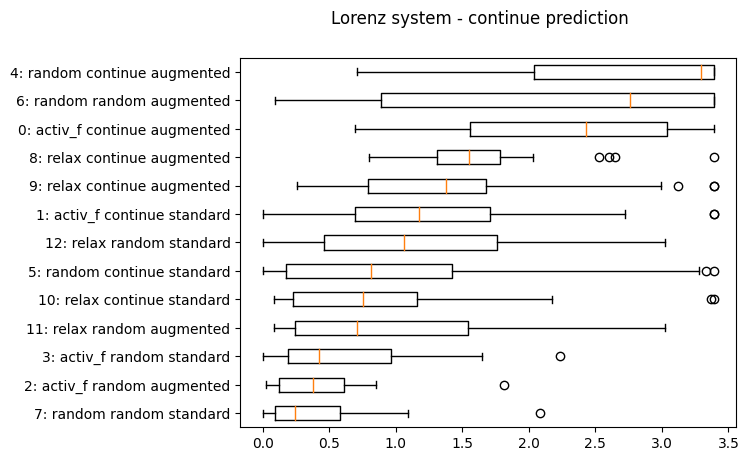

In [26]:
boxplots(results_split['lorenz'], 'continue')
plt.suptitle('Lorenz system - continue prediction')
plt.show()

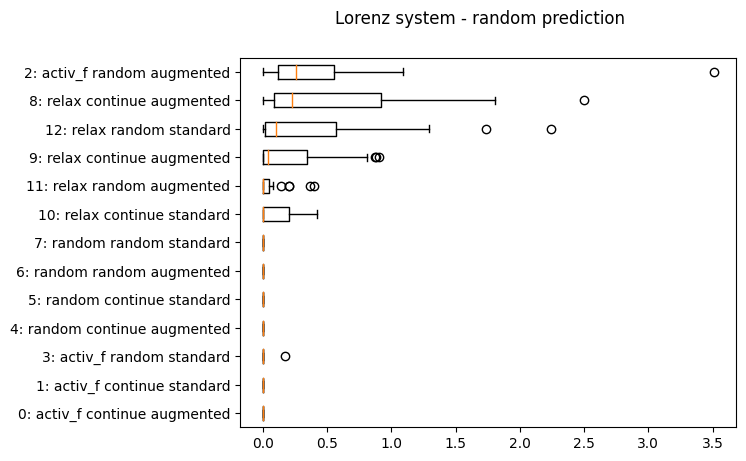

In [9]:
boxplots(results_split['lorenz'], 'random')
plt.suptitle('Lorenz system - random prediction')
plt.show()

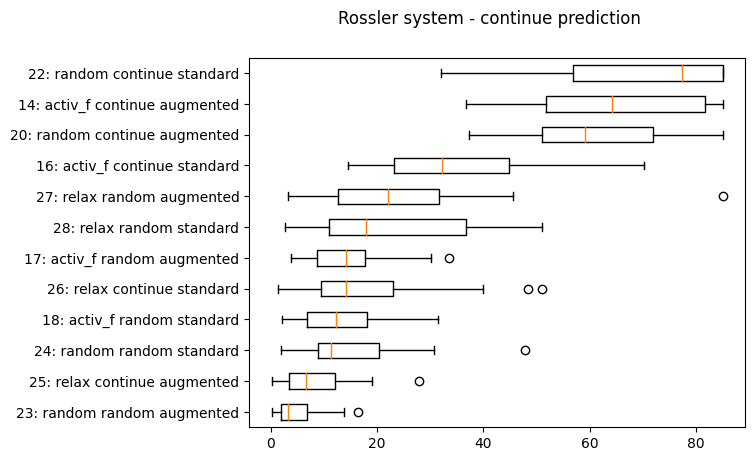

In [10]:
boxplots(results_split['rossler'], 'continue')
plt.suptitle('Rossler system - continue prediction')
plt.show()

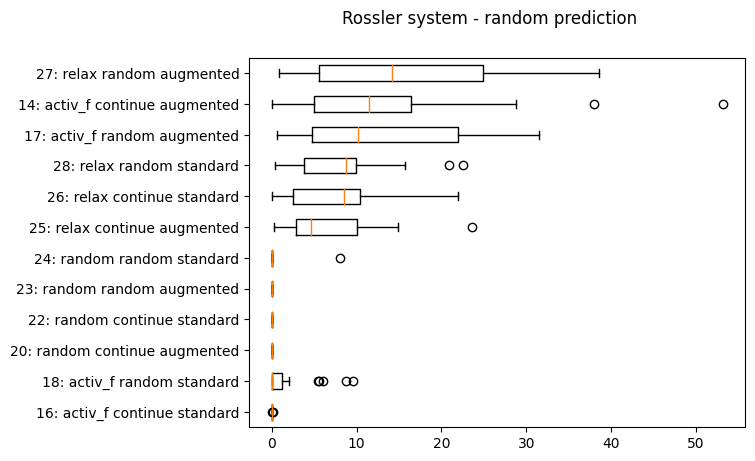

In [11]:
boxplots(results_split['rossler'], 'random')
plt.suptitle('Rossler system - random prediction')
plt.show()

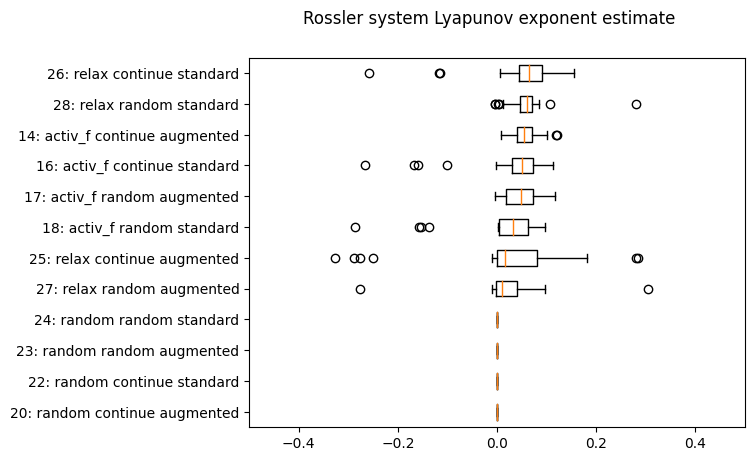

In [27]:
boxplots(results_split['rossler'], 'lyapunov',force_finite=True)
plt.suptitle('Rossler system Lyapunov exponent estimate')
plt.xlim(-0.5,0.5)
plt.show()

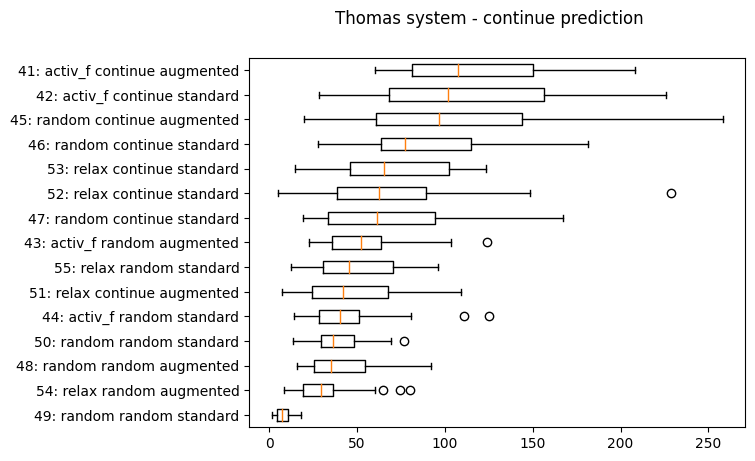

In [13]:
boxplots(results_split['thomas'], 'continue')
plt.suptitle('Thomas system - continue prediction')
plt.show()

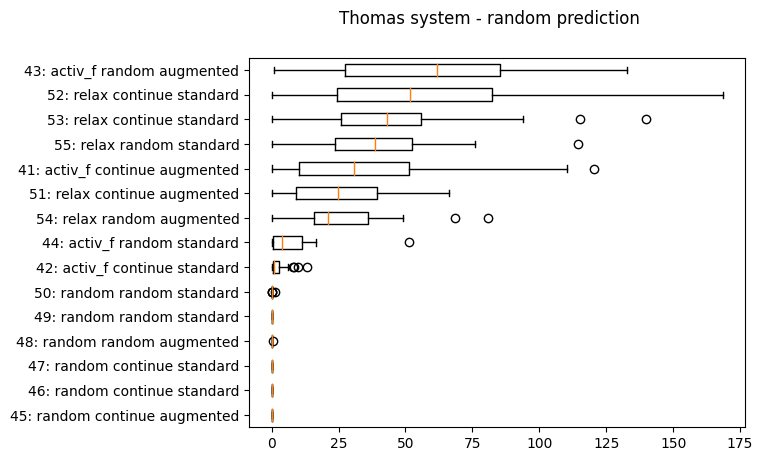

In [14]:
boxplots(results_split['thomas'], 'random')
plt.suptitle('Thomas system - random prediction')
plt.show()

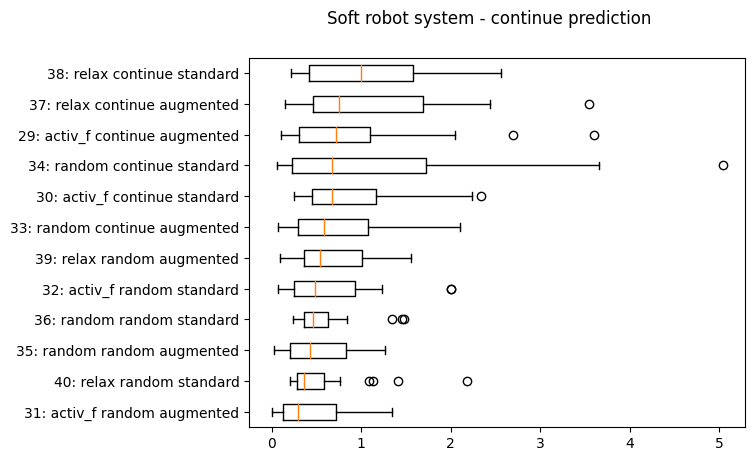

In [15]:
boxplots(results_split['softrobot'], 'continue')
plt.suptitle('Soft robot system - continue prediction')
plt.show()

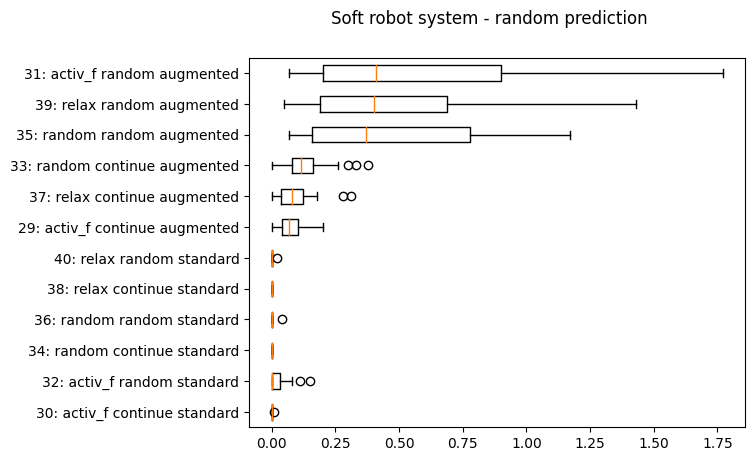

In [16]:
boxplots(results_split['softrobot'], 'random')
plt.suptitle('Soft robot system - random prediction')
plt.show()

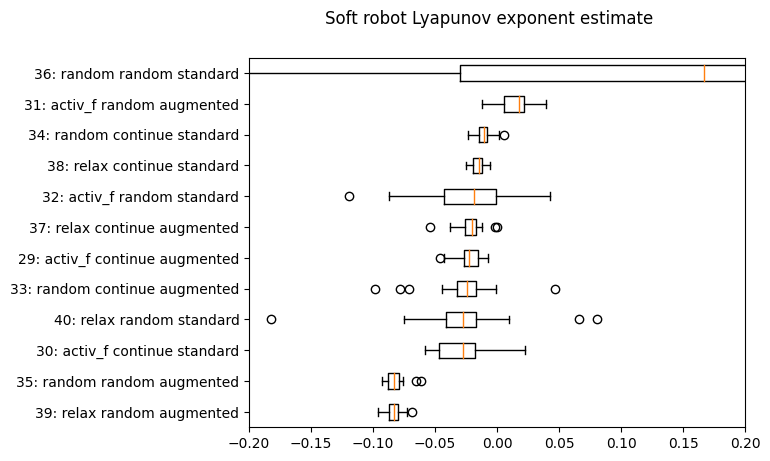

In [17]:
boxplots(results_split['softrobot'], 'lyapunov')
plt.suptitle('Soft robot Lyapunov exponent estimate')
plt.xlim(-0.2,0.2)
plt.show()